In [ ]:
from pathlib import Path
from fastai.basics import *
from fastai.vision.data import get_image_files

In [ ]:
path=Path('./danbooru2020')
image_path=path/'512px/'
meta=Path('metadata/2020')

In [ ]:
def read_json_filter(p,dtype={'id':np.uint32,'image_width':np.uint16,'image_height':np.uint16},columns=['id','image_width', 'image_height','tags']):
    table=pd.read_json(p,orient='records',typ='frame',lines=True,dtype=dtype)
    table[table['rating']=='s']
    return table[columns]

### Images, Metadata Overlap

In [ ]:
def image_meta_overlap(paths,image_path):
    filename_to_id=lambda p:int(re.compile(r'(\d+).jpg').sub(r'\1',p.name))
    image_ids=get_image_files(image_path).map(filename_to_id)
    joined_ids=pd.Series(data=[],dtype=np.uint32)
    for i,p in enumerate(paths):
        print(i,end=',')
        ids=read_json_filter(p,columns=['id'])
        ids=ids[ids['id'].isin(image_ids)]
        joined_ids=joined_ids.append(ids['id'],ignore_index=True)
    return joined_ids.sort_values(ignore_index=True)

In [ ]:
image_ids=image_meta_overlap(get_files(meta),image_path)
image_ids[:5],len(image_ids)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,

(0    1
 1    2
 2    3
 3    4
 4    7
 dtype: uint32,
 3227426)

### Aggregate tags 

In [ ]:
def tags_by_file(table,aggregate_tags={}):
    for tags in table['tags']: 
        for tag in tags:
            if tag['name'] in aggregate_tags:
                aggregate_tags[tag['name']]['count']+=1
            else:
                aggregate_tags[tag['name']]={'id':int(tag['id']),'category':int(tag['category'])}
                aggregate_tags[tag['name']]['count']=1
    return aggregate_tags
def tags_by_name(paths):
    named_tags={}
    for i,p in enumerate(paths):
        print(i,end=',')
        table = read_json_filter(p)
        table = table[table.id.isin(image_ids)]
        named_tags=tags_by_file(table,named_tags)
    return named_tags

In [ ]:
get_files(meta)

(#16) [Path('metadata/2020/2020000000000000'),Path('metadata/2020/2020000000000001'),Path('metadata/2020/2020000000000002'),Path('metadata/2020/2020000000000003'),Path('metadata/2020/2020000000000004'),Path('metadata/2020/2020000000000006'),Path('metadata/2020/2020000000000007'),Path('metadata/2020/2020000000000008'),Path('metadata/2020/2020000000000009'),Path('metadata/2020/2020000000000010')...]

In [ ]:
named_tags=tags_by_name(get_files(meta))

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,

In [ ]:
with open('named_tags' + '.pkl', 'wb') as f: pickle.dump(named_tags, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
def tags_by_id(tags_list):
    return {tag['id']:name for name,tag in tags_list}
id_tags=tags_by_id(named_tags.items())

In [ ]:
with open('id_tags' + '.pkl', 'wb') as f: pickle.dump(id_tags, f, pickle.HIGHEST_PROTOCOL)

### Analyze Tag counts

In [ ]:
tag_counts=sorted(map(lambda t:t['count'],named_tags.values()))

In [ ]:
len(tag_counts)-len(list(filter(lambda t:t!=1,tag_counts)))

128358

In [ ]:
tag_count=array(tag_counts)

In [ ]:
id_tags[470575],len(id_tags)

('1girl', 396177)

In [ ]:
tag_counts[234000],tag_counts[-1]

(4, 2185664)

Tags are heavily scewed to a smaller subset of more popular tags. 

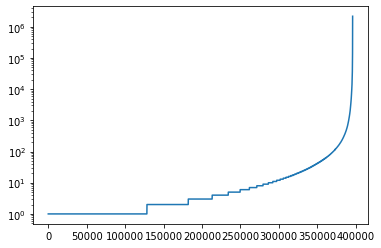

In [ ]:
plt.yscale("log")
plt.plot(tag_counts[:])

In [ ]:
len(image_ids)

3227426

### Concat Tables 

Restart notebook here if run out of memory

Freeing up some memory

In [ ]:
with open('image_ids' + '.pkl', 'wb') as f: pickle.dump(image_ids, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
del named_tags
del id_tags
del tag_count
del tag_counts
del image_ids

In [ ]:
with open('image_ids.pkl','rb') as f: image_ids=pickle.load(f)

In [ ]:
def numericalize_tags(tags_column):
    num_tags=[]
    for tags in tags_column:
        tgs=L(tags).map(lambda t:t['id']).map(int)
        tgs=pd.array(list(tgs),dtype='UInt32')
        num_tags+=[tgs]
    return num_tags
def concat_tables(paths):
    concat_table=None
    numeric_tags=[]
    for i,p in enumerate(paths):
        print(i,end=',')
        table = read_json_filter(p)
        table = table[table.id.isin(image_ids)]
        if(concat_table is not None): concat_table=pd.concat([concat_table,table.drop('tags', axis=1).copy()],ignore_index=True)
        else: concat_table=table.drop('tags', axis=1).copy()
        numeric_tags+=numericalize_tags(table['tags'])
    concat_table['tags']=pd.Series(numeric_tags)
    return concat_table

In [ ]:
full_table=concat_tables(get_files(meta))

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,

In [ ]:
full_table['image_width'].dtype

dtype('uint16')

In [ ]:
full_table.id.shape #should be 3209092?!?

(3227426,)

In [ ]:
full_table.to_pickle('fulll_table.pkl')

We now have a way to access all relevant data in ram memory in a fairly data efficient way. Taking ~4 GB as opposed to 100+ GB. Converting the tags to unsigned ints as opposed to dictionaries of strings.